Import Libraries

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import glob as glob
import sys as sys
import csv as csv
import random as rand
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from kapre.composed import get_melspectrogram_layer
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, TimeDistributed
from sklearn import metrics
from keras import models, losses, optimizers, callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The provided zip file has N file pairs of melspectograms and eventrolls, i.e., (melspec_00001.npy, eventroll_00001.npy),(melspec_00002.npy, eventroll_00002.npy), ...

A melspectrogram file has a shape of (1, 512, 1000). It can be thought as an image having one channel, height=512 and width=1000.
An eventroll matrix file has a shape of (11, 1000). Which represents 11 (0 to 10) different arrays where each array represents that 
whether event is on for that timestamp or not for that event type. It has value 1 if event on and 0 for event off. 

For example, if eventroll[4, 50:250] = 1, then it means that the event type no 4 (here sound of a dog) starts at timestamp 50 and length of event is 250 - 50 = 200 timestamps. Note that for each event type, there can be multiple events of same type in an eventroll for some event.

You have to predict the events present in an spectrogram (not their timestamps).
An additional python script eventroll_to_multihot_vector.py is given to convert eventrolls in the desired format.

The files provided are numpy arrays which can be loaded using np.load("<filename>.npy", allow_pickle=True)




In [38]:
classes= {'Alarm_bell_ringing':0, 'Blender':1, 'Cat':2, 'Dishes':3, 'Dog':4, 'Electric_shaver_toothbrush':5, 'Frying':6, 'Running_water':7, 'Silence':8, 'Speech':9, 'Vacuum_cleaner':10}
classes_without_silence= {'Alarm_bell_ringing':0, 'Blender':1, 'Cat':2, 'Dishes':3, 'Dog':4, 'Electric_shaver_toothbrush':5, 'Frying':6, 'Running_water':7, 'Speech':8, 'Vacuum_cleaner':9}
classnames= ['Alarm_bell_ringing', 'Blender', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush', 'Frying', 'Running_water', 'Silence', 'Speech', 'Vacuum_cleaner']
classnames_without_silence= ['Alarm_bell_ringing', 'Blender', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush', 'Frying', 'Running_water', 'Silence', 'Speech', 'Vacuum_cleaner']

reverse_mapping= {} # Reverse mappping to correlate list indices with list names
for c in classes_without_silence: 
    reverse_mapping[classes_without_silence[c]]=c
print(reverse_mapping)



{0: 'Alarm_bell_ringing', 1: 'Blender', 2: 'Cat', 3: 'Dishes', 4: 'Dog', 5: 'Electric_shaver_toothbrush', 6: 'Frying', 7: 'Running_water', 8: 'Speech', 9: 'Vacuum_cleaner'}


In [39]:
import numpy as np

def eventroll_to_multihot_vector(eventroll):  # Y contains the labels in the form of eventrolls. This function converts eventrolls to multihot vectors
    """
    Parameters
    ----------
    eventroll : np.array
        Eventroll matrix of shape=(11, 1000).
    
    Returns
    -------
    np.array
        A multihot vector of shape=(10,)
    """
    
    # findout active events:
    active_events = (eventroll.sum(axis=1) >= 0.5).astype('float')
    # print("eventroll.sum(axis=1)= ",eventroll.sum(axis=1))
    # print("active events= ", active_events)
    # print("events= ",np.delete(active_events, 8))
    # remove silence class:
    return np.delete(active_events, 8)


In [40]:
def load_data(str, num):  # Loads the data (from the given path) and saves it in a particular format
	train = {}
	max_len=0  																													
	for np_name in glob.glob(str+'*.npy'):
		train[np_name[num+8:]] = np.load(np_name) # 8 = melspec_ => Only the numeric part of the label gets associated to the dataset
	return train 

def get_labels1(str,num):
  labels= {}
  for name in glob.glob(str+ "*.npy"):
    temp = eventroll_to_multihot_vector(np.load(name))
    labels[name[num+10:]] = temp # 10 = eventroll_ => Only the numeric part of the label gets associated to the label
  return labels

def create_X(train):	 
	X=[]
	for t in train:
			X.append(train[t])
	return X

def create_features(train, labels):
    X=[]
    y=[]
    for t in train:
        if(t in labels.keys()):
            X.append(train[t])	
            y.append(labels[t])
    return X,y
  
def create_features_one_step(str1, str2): # Loads data, creates labels, creates features - all in one step
    train= load_data(str1, len(str1)) 
    labels= get_labels1(str2,len(str2))
    X,y = create_features(train, labels) 
    return X,y
  
def convert_to_numpy_array(X,y):  # Converts the lists X and Y to numpy arrays
    X= np.array(X)
    y= np.array(y)
    return X,y

def print_shape(X,y): # Prints shapes of the given arrys
    print("X has shape:",X.shape)
    print("y has shape:",y.shape)

In [41]:
X,y= create_features_one_step('/content/drive/MyDrive/Assignment 2/sed_dataset/sed_dataset/dataset/X/', '/content/drive/MyDrive/Assignment 2/sed_dataset/sed_dataset/dataset/Y/') # For data set
X_test, y_test= create_features_one_step('/content/drive/MyDrive/Assignment 2/sed_dataset/sed_dataset/validation/dataset/X/', '/content/drive/MyDrive/Assignment 2/sed_dataset/sed_dataset/validation/dataset/Y/')  # For validation set
ind=1

In [42]:
def padding( X ,max_len):  #returns padded audio arrays 
    padded_audio= []
    for audio in X: 
        # add a random amount of padding at the beginning, and add more at the end so that every array in X will have same dims
        dim= audio.shape[1]
        signal_length= audio.shape[2]
        if(signal_length<max_len):
            start_padding = rand.randint(0, max_len - signal_length)
            end_padding = max_len - signal_length - start_padding
            left= np.zeros((1,dim, start_padding))
            right= np.zeros((1, dim, end_padding))
            temp= np.concatenate((left, audio), axis=2)
            audio= np.concatenate((temp, right), axis=2)
        else:
            audio= audio[:,:,:max_len]
        padded_audio.append(audio)
    return padded_audio

In [43]:
pre_padded_X= X
max_len= 700
X= padding(X, max_len= max_len)
X_test= padding(X_test, max_len= max_len)
sh= X[0].shape
print("The size of every numpy tensor in X should now be ", sh)
for audio in X: 
    if(audio.shape!=sh):
        raise Exception("Padding has been done incorrectly")
print("Padding done successfully")

The size of every numpy tensor in X should now be  (1, 64, 700)
Padding done successfully


In [44]:
X,y= convert_to_numpy_array(X,y)
print_shape(X, y)

X has shape: (10000, 1, 64, 700)
y has shape: (10000, 10)


In [45]:
X_test, y_test= convert_to_numpy_array(X_test, y_test)
print_shape(X_test, y_test)

X has shape: (2000, 1, 64, 700)
y has shape: (2000, 10)


## Data visualisation:

[0. 0. 0. 1. 0. 0. 0. 1. 1. 0.] [3 7 8]
[0. 0. 0. 1. 0. 0. 1. 0. 1. 0.] [3 6 8]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] [8 9]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [8]
[0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] [4 8]
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] [5 8]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] [8 9]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] [7 8]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.] [1 8]
10


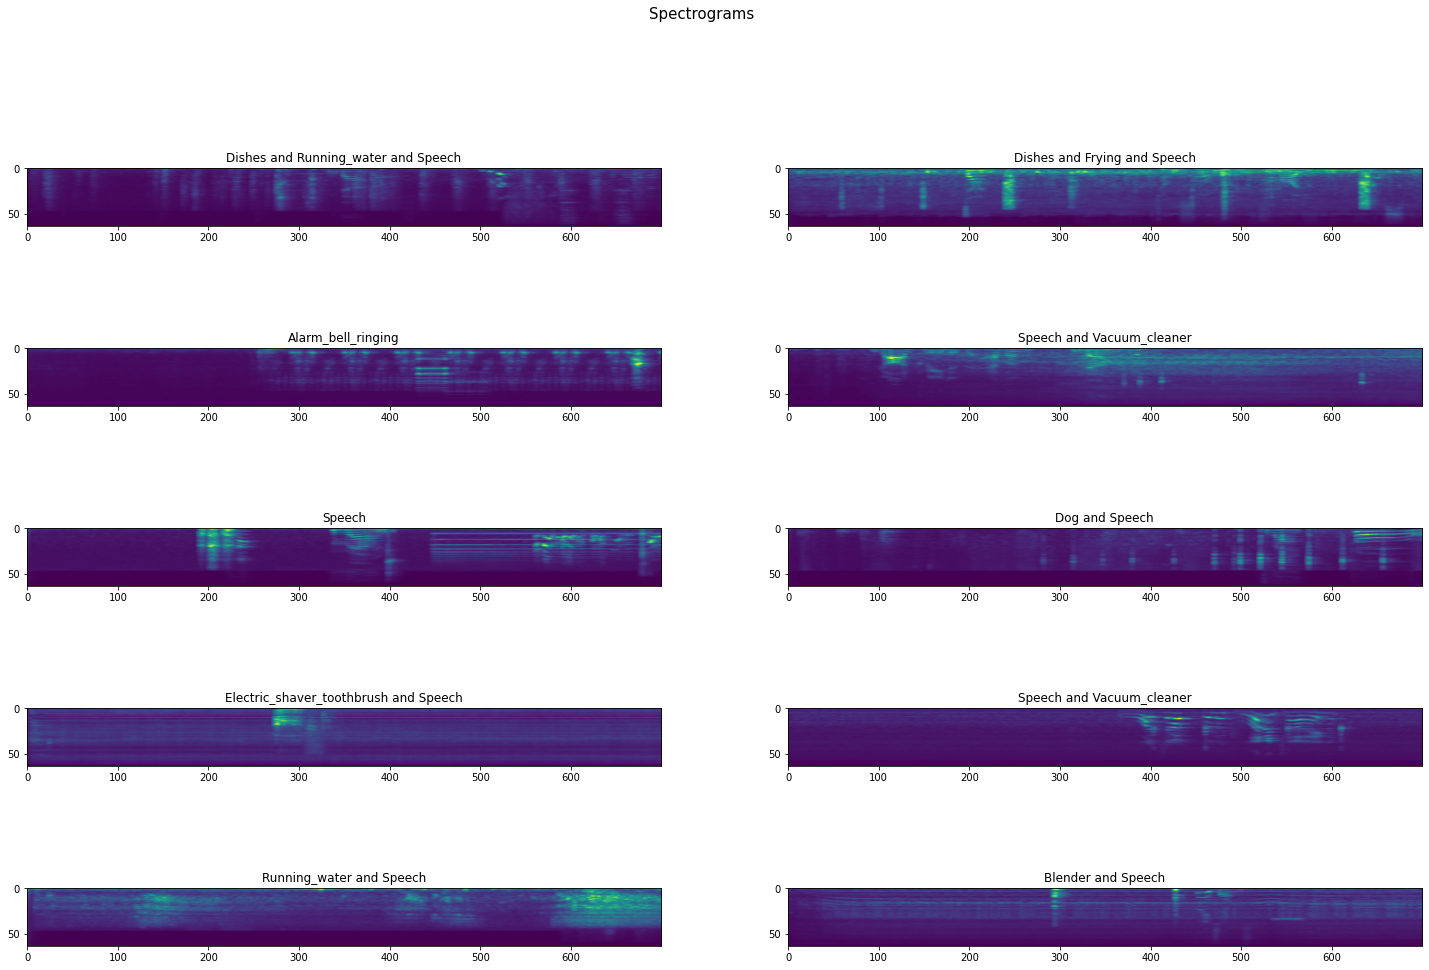

In [46]:
def plot_spectrogram(titles, signals, title, shape=(16,8)):	# Used imshow
    r, c = 5, 2
    fig, ax = plt.subplots(r, c, figsize=shape)
    fig.suptitle(title, size=15)
    plt.set_cmap('viridis')
    z = 0
    for i in range(r):
        for y in range(c):
            ax[i,y].set_title(titles[z])
            ax[i,y].imshow(signals[z].squeeze()) # Need to squeeze out first dimension to plot images 
            z += 1
    plt.show()
    
titles = []
signals = []

for i in range(96,106):
	s=""
	# print(y[i].shape)
	ind= np.where(y[i] == 1)[0]
	print(y[i], ind)
	for num in ind:
		s+=reverse_mapping[num]
		s+=" and "
	s= s[:-5]
	titles.append(s)
	temp= X
	signals.append(X[i])
print(len(signals))
plot_spectrogram(titles, signals, title='Spectrograms', shape=(25,16))

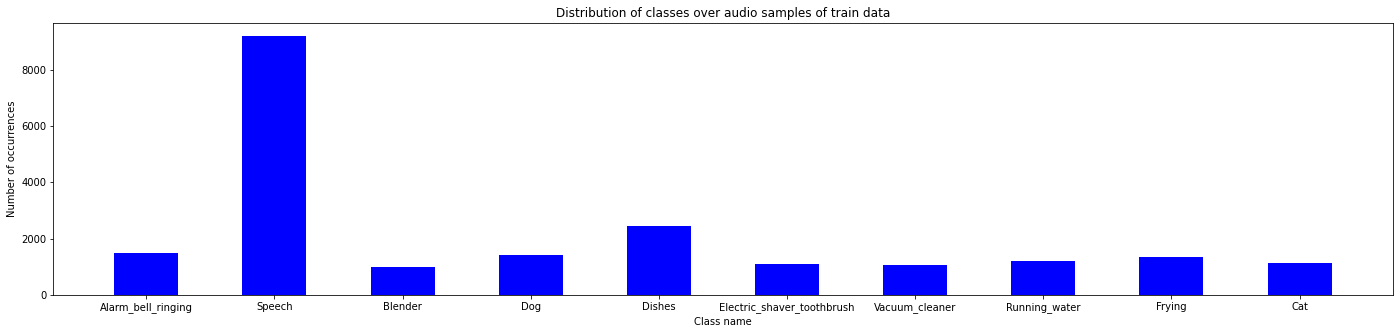

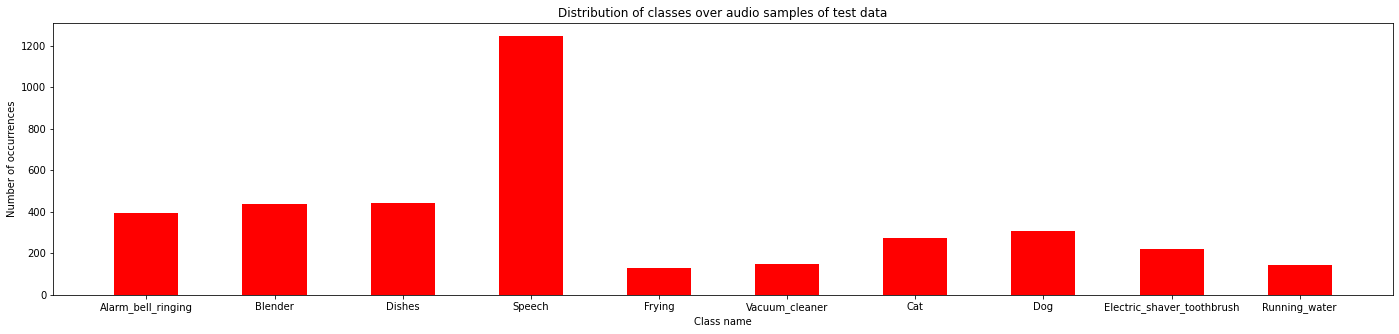

In [47]:
def extract_distribution(X,y,str, flag): #Prints the distribution of classes over audio samples
    tags={}
    for i in range(X.shape[0]):
        ind= np.where(y[i] == 1)[0]
        # print(ind)
        for j in ind:
            tags[reverse_mapping[j]]= tags.get(reverse_mapping[j], 0)+1
    # print(tags)
    courses = list(tags.keys())
    values = list(tags.values())
    fig = plt.figure(figsize = (24, 5))
    color='blue'
    if(flag):
        color= 'red'
    plt.bar(courses, values, color = color, width = 0.5)
    plt.xlabel("Class name")
    plt.ylabel("Number of occurrences")
    plt.title("Distribution of classes over audio samples of " + str + " data" )
    plt.show()
    
extract_distribution(X,y,"train",0)
extract_distribution(X_test,y_test,"test",1)

In [48]:
print("old train shape:",X.shape)
X= np.moveaxis(X, 1, -1)  # We need the 1 at the end - image classification logic - one dimensional image
print("new train shape:",X.shape)
print("old test shape:",X_test.shape)
X_test= np.moveaxis(X_test, 1, -1)
print("new test shape:",X_test.shape)

old train shape: (10000, 1, 64, 700)
new train shape: (10000, 64, 700, 1)
old test shape: (2000, 1, 64, 700)
new test shape: (2000, 64, 700, 1)


In [49]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [50]:
model = Sequential()

model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), activation="relu", input_shape=(64,max_len,1), padding="same"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))


In [51]:
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), 'accuracy', f1_m, precision_m, recall_m])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 700, 8)        80        
                                                                 
 batch_normalization_10 (Bat  (None, 64, 700, 8)       32        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 350, 8)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 32, 350, 8)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 350, 16)       3216      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 175, 16)     

In [52]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [53]:
es = EarlyStopping(monitor='val_binary_accuracy',mode='max',patience=2,verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
check = ModelCheckpoint(filepath = 'my_best_model.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='min')
callbacks= [es, check]

In [54]:
history = model.fit(X, y, epochs=3, validation_data=(X_test, y_test), batch_size=64, callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - 13s 69ms/step - loss: 0.4902 - binary_accuracy: 0.8135 - accuracy: 0.1135 - f1_m: 0.5363 - precision_m: 0.6257 - recall_m: 0.4872 - val_loss: 0.4812 - val_binary_accuracy: 0.8375 - val_accuracy: 0.0480 - val_f1_m: 0.4338 - val_precision_m: 0.6245 - val_recall_m: 0.3327
Epoch 2/10
157/157 [==============================] - 8s 54ms/step - loss: 0.4168 - binary_accuracy: 0.8595 - accuracy: 0.1131 - f1_m: 0.5811 - precision_m: 0.8030 - recall_m: 0.4563 - val_loss: 0.5013 - val_binary_accuracy: 0.8375 - val_accuracy: 0.0480 - val_f1_m: 0.4338 - val_precision_m: 0.6245 - val_recall_m: 0.3327
Epoch 3/10
157/157 [==============================] - 8s 54ms/step - loss: 0.3837 - binary_accuracy: 0.8661 - accuracy: 0.1123 - f1_m: 0.5926 - precision_m: 0.8484 - recall_m: 0.4559 - val_loss: 0.5301 - val_binary_accuracy: 0.8375 - val_accuracy: 0.0480 - val_f1_m: 0.4338 - val_precision_m: 0.6245 - val_recall_m: 0.3327
Epoch 3: early stopping


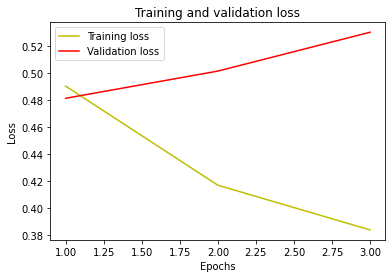

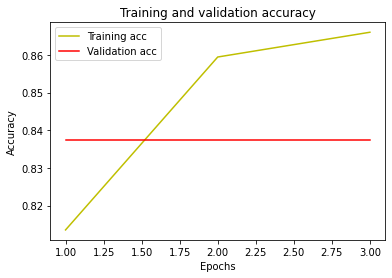

In [55]:
#plot the training and validation accuracy and loss at each epoch

model.save("mymodel_final")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
str5='/content/drive/MyDrive/Assignment 2/test/test/X/'
test= load_data(str5, len(str5))                                                # Load the test data
# print(test)
X_test= padding(create_X(test), max_len)
X_test = np.array(X_test)
print(X_test.shape)                                                             # Print test shape (Expected to be size, 1, 128, 500)
X_test= np.moveaxis(X_test, 1, -1)                                              # Shifting the axis - CNNs are usually used for image mapping which have a 3D structure, the thirs dimension being colours (RGB). In audios, we do not need the third dimension - hence, the 1 has to be placed in the last spot.
y_pred= model.predict(X_test, batch_size= 50, verbose=1)
print(y_pred[0])
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if(y_pred[i][j]>0.25):
            y_pred[i][j]= 1
        else:
            y_pred[i][j]=0

predictions= []
for pred in y_pred:
    s= ""
    for t in range(pred.shape[0]):
      if(pred[t]==1):
          s+=reverse_mapping[t]
          s+=","
      string= s[:-1]
    predictions.append(string)                                   # Reverse map the numeric values to actual labels
fileid=[]
for t in test:
  # if(len(fileid)==len(predictions)):                                          # Appending the field id to the tensor
  #   break
  fileid.append("melspec_"+t)
d = {'fileid':fileid, 'prediction': predictions}                                # Creating a dataframe => csv
df = pd.DataFrame(data= d)
df.to_csv('predictions.csv')


(2500, 1, 64, 700)
50/50 [==============================] - 1s 15ms/step
[0.04101037 0.09957262 0.03677943 0.34407586 0.03929674 0.22763722
 0.23662814 0.16214705 0.8997284  0.31099644]


In [70]:
# y_pred= np.reshape(y_pred, (y_pred.shape[0],1))
# print(y_pred.shape)
# print(y_pred[0])
# for i in range(y_pred.shape[0]):
#     for j in range(y_pred.shape[1]):
#         if(y_pred[i][j]>0.5):
#             y_pred[i][j]= 1
#         else:
#             y_pred[i][j]=0
         
# print(classnames)
# print(y_pred.shape)
# print(y_test.shape)
# # print(y_test[0])
# conf_mat = multilabel_confusion_matrix(y_test, y_pred)
# print(conf_mat.shape)
# print(conf_mat)
# titles= []
# for i in range(conf_mat.shape[0]):
# 	titles.append(reverse_mapping[i])

# r, c = 5, 2
# fig, ax = plt.subplots(5, 2, figsize=(10, 8))
# fig.suptitle("Confusion Matrices", size=15)
# plt.set_cmap('viridis')
# z = 0
# for i in range(5):
# 	for y in range(2):
# 		print(i,y)
# 		ax[i,y].set_title(titles[z])
# 		ax[i,y].imshow(conf_mat[z])
# 		for t in range(2):
# 			for j in range(2):
# 				text = ax[i][y].text(t, j, int(conf_mat[z][t][j]),
# 							ha="center", va="center", color="w")
# 		z += 1
# fig.tight_layout()
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.show()